In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# NLTK modules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Thinkpad
[nltk_data]     T480\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Thinkpad
[nltk_data]     T480\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the Dataset

df = pd.read_csv('IMDB Dataset.csv')
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# Exploratory Data Analysis (EDA)

print("\nColumn names:", df.columns)
print("\nData types:\n", df.dtypes)
print("\nChecking duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)


print("\nChecking missing values:\n", df.isnull().sum())


Column names: Index(['review', 'sentiment'], dtype='object')

Data types:
 review       object
sentiment    object
dtype: object

Checking duplicates: 418
After removing duplicates: (49582, 2)

Checking missing values:
 review       0
sentiment    0
dtype: int64


C:\Users\Thinkpad T480\AppData\Local\Temp\ipykernel_9144\2287768260.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


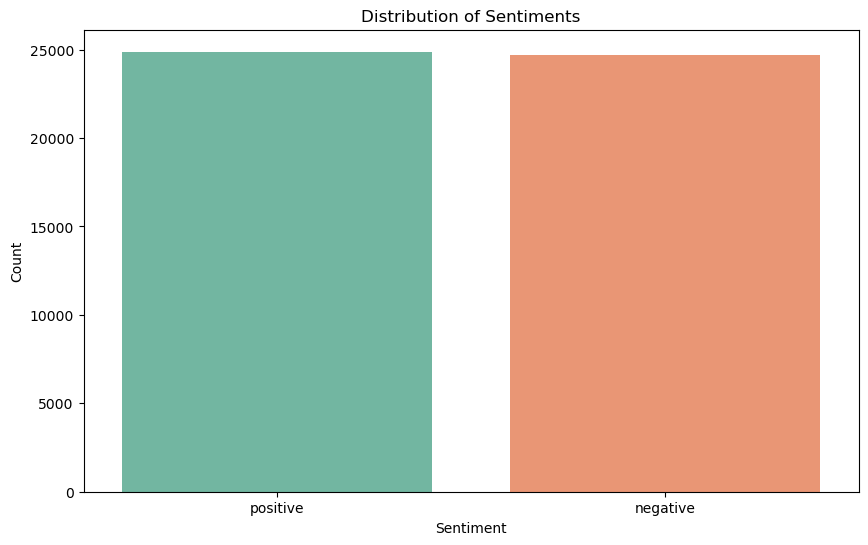

In [6]:
# Sentiment distribution
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count');

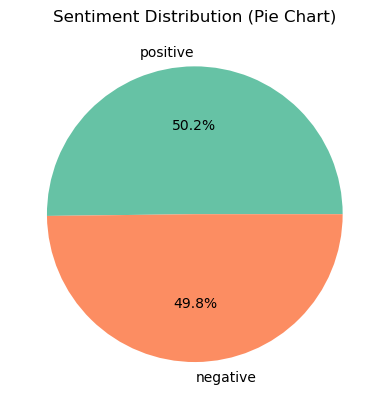

In [7]:
# Pie chart for sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%',
colors=sns.color_palette('Set2', len(sentiment_counts)))
plt.title('Sentiment Distribution (Pie Chart)')
plt.ylabel('') # Hides the y-axis label
plt.show()

In [8]:
# Data Preprocessing

# Encode Sentiments (Binary Values):
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print(df['sentiment'].value_counts()) # Count of positive and negative sentiments

stop_words = set(stopwords.words('english'))
def preprocess_text(review):
    review = re.sub(r'/W', ' ', review)
    review = review.lower()
    words = review.split()

    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(preprocess_text)

sentiment
1    24884
0    24698
Name: count, dtype: int64


In [9]:
# Split the Data

X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Text Vectorization

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print(X_train_tfidf.shape, X_test_tfidf.shape)

(39665, 5000) (9917, 5000)


In [14]:
# Model Training

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [15]:
# Model Evaluation

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8533830795603509
Precision: 0.8480837613591465
Recall: 0.8623945359582161
F1-score: 0.8551792828685258

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4939
           1       0.85      0.86      0.86      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



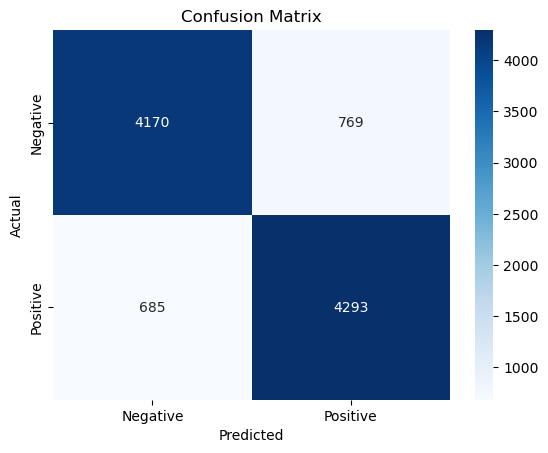

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
# Identify Important Words

feature_names = tfidf.get_feature_names_out()

# Access feature_log_prob_ instead of coef_

sorted_indices = model.feature_log_prob_[0].argsort()
top_positive = [(feature_names[i], model.feature_log_prob_[0][i]) for i in sorted_indices[-10:]]
top_negative = [(feature_names[i], model.feature_log_prob_[0][i]) for i in sorted_indices[:10]]

print("Top Positive Words:", top_positive)

print("Top Negative Words:", top_negative)

Top Positive Words: [('would', -5.865703647684448), ('it', -5.847925108828027), ('good', -5.833660848401935), ('even', -5.790610155580675), ('like', -5.592849071392166), ('bad', -5.572198945851959), ('one', -5.540475060319059), ('film', -5.172967491993847), ('movie', -4.843443078677072), ('br', -4.269500815821418)]
Top Negative Words: [('custer', -11.660849216488176), ('felix', -11.24382366680941), ('miyazaki', -11.093751178324268), ('matthau', -10.974582316593839), ('superbly', -10.91071415724779), ('flawless', -10.812252345254949), ('understated', -10.810344578367495), ('loneliness', -10.776071707847516), ('uplifting', -10.701885836361075), ('cassavetes', -10.691085417917327)]


In [19]:
# Save vectorizer

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
# Save the model

with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
